In [327]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import copy

### Define function to learn and set dataset size

In [346]:
def random_function(x):
    return 2**x

num_data_pts = 100
data_range = [-5, 5]

### Defining a basic neural net

In [347]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the neural network class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        # Define layers
        self.fci = nn.Linear(input_size, hidden_sizes[0])
        self.fch = nn.ModuleList()  # Use ModuleList for registering hidden layers
        for i in range(len(hidden_sizes) - 1):
            self.fch.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
        self.fco = nn.Linear(hidden_sizes[-1], output_size)
        self.relu = nn.ReLU()  # ReLU activation

    def forward(self, x):
        # Define forward pass
        out = self.fci(x)
        out = self.relu(out)
        for fch in self.fch:
            out = fch(out)
            out = self.relu(out)
        out = self.fco(out)  # Linear output (no activation for regression)
        return out

# Define the model, loss function, and optimizer
input_size = 1
hidden_sizes = [5, 5, 5, 5]
output_size = 1
learning_rate = 0.0001

model = NeuralNetwork(input_size, hidden_sizes, output_size)

# Loss function: MSE for regression
criterion = nn.MSELoss()

# Optimizer: Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Generate training data
X_sample = ((np.random.rand(num_data_pts) * (data_range[1] - data_range[0])) + data_range[0]).reshape(num_data_pts, 1)
y_sample = random_function(X_sample)

# Convert training data to PyTorch tensors
X = torch.tensor(X_sample, dtype=torch.float32)  # Inputs
y = torch.tensor(y_sample, dtype=torch.float32)  # Outputs (labels)

# Train the network
epochs = 10000
for epoch in range(epochs):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)

    # Backward pass and optimization
    optimizer.zero_grad()  # Zero the gradient buffers
    loss.backward()        # Backpropagate the error
    optimizer.step()       # Update weights

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Test the trained network
with torch.no_grad():  # No need to calculate gradients during testing
    predicted = model(X)

original_model_weights = copy.deepcopy(model.state_dict())

Epoch [1000/10000], Loss: 61.0745
Epoch [2000/10000], Loss: 35.5909
Epoch [3000/10000], Loss: 10.4830
Epoch [4000/10000], Loss: 5.9466
Epoch [5000/10000], Loss: 3.8927
Epoch [6000/10000], Loss: 2.3632
Epoch [7000/10000], Loss: 1.7187
Epoch [8000/10000], Loss: 1.5263
Epoch [9000/10000], Loss: 1.5038
Epoch [10000/10000], Loss: 1.4960


### Plotting predictions on true values

1.4959931373596191


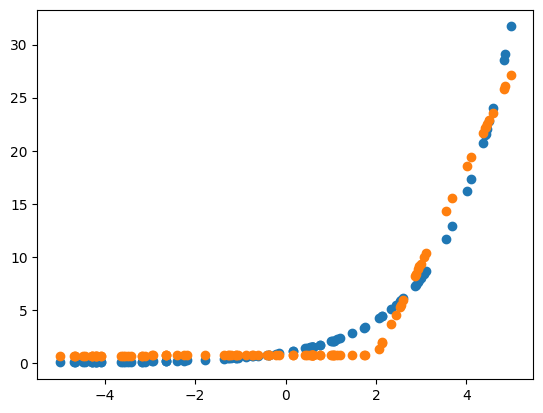

In [348]:
plt.scatter(X, y)
plt.scatter(X, predicted)
original_loss = criterion(predicted, y).item()
print(original_loss)

### Visualizing the distribution of weights

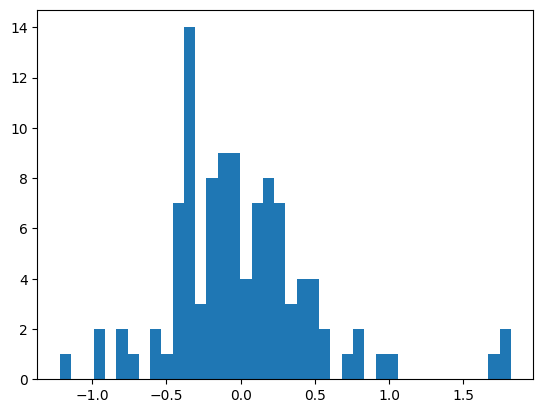

In [349]:
hist1 = plt.hist(torch.cat([torch.ravel(x) for x in model.state_dict().values()], 0), bins = 40)

### Defining an alphabet

In [350]:
quant_alphabet = np.array([-5, -1, 0, 1, 5]).astype(np.float64)
def find_nearest(x, quant_alphabet):
    return quant_alphabet[np.argmin(np.abs(x - quant_alphabet))]


### Testing out various round granularities as quantization techniques

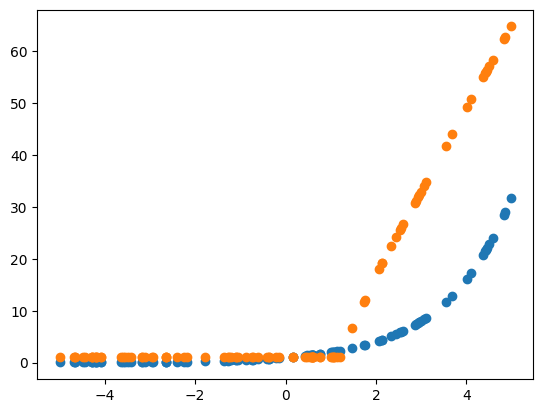

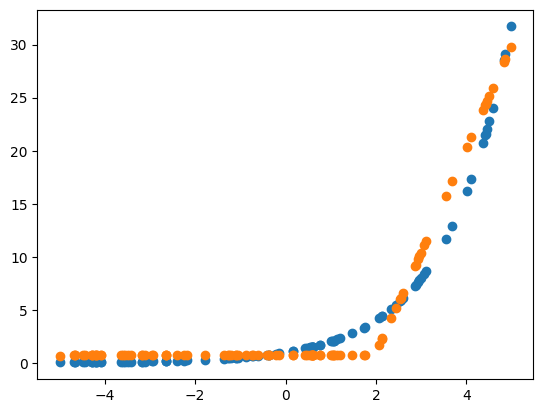

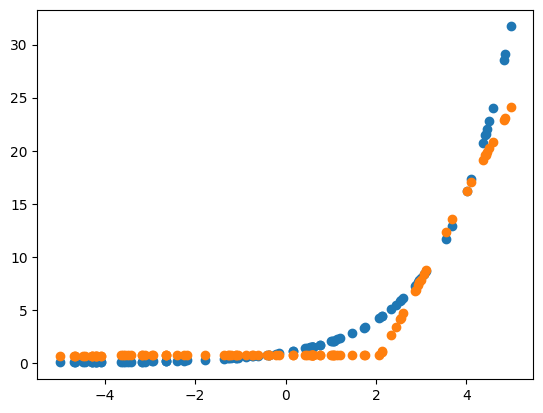

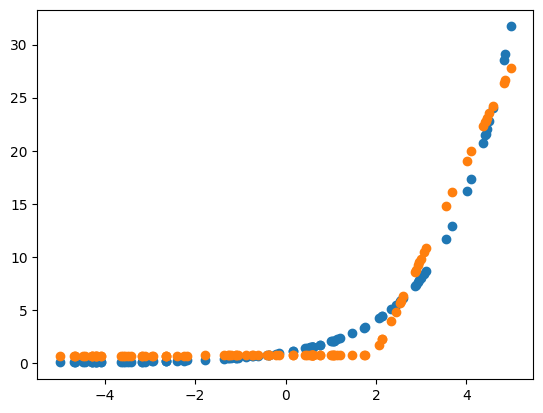

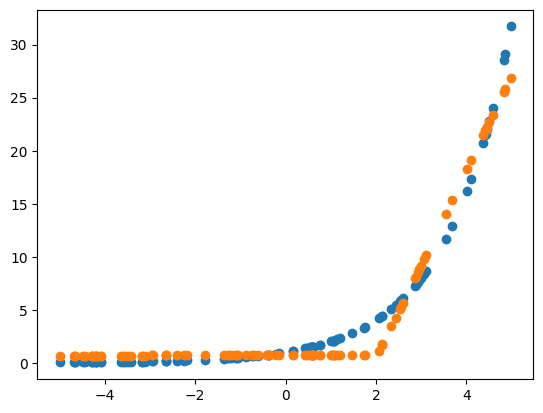

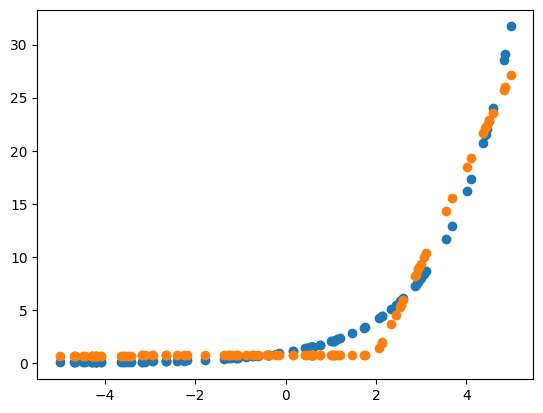

In [351]:
metrics = dict()

for g in [0, 1, 5, 10, 25, 50, 100]:
    if g == 0:
        continue
    
    g = 1.0 * g
    
    temp = copy.deepcopy(original_model_weights)
    
    for k, v in model.state_dict().items():
        temp[k] = temp[k].apply_(lambda x: round(x * g) / g)

    model.load_state_dict(temp)

    with torch.no_grad():
        predicted_quant = model(X)

    plt.figure(g)
    plt.scatter(X, y)
    plt.scatter(X, predicted_quant)
    size = np.float64(torch.log2(torch.tensor(list(torch.cat([torch.ravel(x) for x in model.state_dict().values()], 0).unique().size())))[0])
    loss = criterion(predicted_quant, y).item()
    metrics[g] = [size, loss]

### Visualizing the loss vs. compression for our algorithm

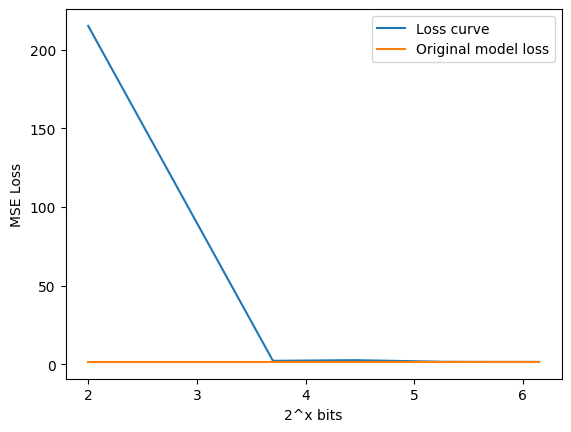

In [353]:
metrics_data = np.array(list(metrics.values()))
plt.plot(metrics_data[:, 0], metrics_data[:, 1])
plt.plot(metrics_data[:, 0], [original_loss] * metrics_data.shape[0])
plt.xlabel("2^x bits")
plt.ylabel("MSE Loss")
plt.legend(["Loss curve", "Original model loss"])